Student name: Connor Pate
Student pace: part time
Blog post URL: https://medium.com/@clpate2

Scheduled project review date/time: 11/19/20 @ 1:15

Instructor name: Amber Yandow 




# The Problem with Mental Health in U.S. Policing

#### Analyzing Mental Health and Demographics using The Washington Post's Police Shooting database

## Directory
#### 1. Importing Necessary Libraries
#### 2. Importing Datasets, Merging, and Inspecting Data
#### 3. Cleaning and Converting Data
     3A. Examining Values 
     3B. Converting Categories and Inspecting New Counts
#### 4. Initial Analysis and EDA 1 of 2
     4A. EDA 2 of 2, Automated EDA
#### 5. Final Prep Stage for Modeling: Scaling Continuous Data and Creating Dummy DF
#### 6. Creating Train/Test Sets and Comparing Methods of Analysis
#### 7. Logistic Regression (Model 1 of 3)
#### 8. Decision Tree Classifier (Model 2 of 3)
#### 9. Random Forest Classifier (Model 3 of 3)
#### 10. Fine Tuning Data - Decision Tree Classifier
    10A. Feature Importance/Selection, prep for SMOTE
    10B. DTC with Oversampling via SMOTE, No Feature Selection
    10C. DTC with Oversampling via SMOTE and Feature Selection
#### 11. Fine Tuning Data - Random Forest Classifier
    11A. Feature Importance/Selection, FS model, prep for SMOTE
    11B. RFC with Oversampling via SMOTE, No Feature Selection
    11C. RFC with Oversampling via SMOTE and Feature Selection
#### 12. Conclusion

### 1. Importing Necessary Libraries 

In [652]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
#import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
import imblearn
from imblearn.over_sampling import SMOTE

from ClfAutoEDA import *
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import svm
from scipy.stats import chisquare
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor  
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from numpy import mean
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.svm import SVC



### 2. Importing Datasets, Merging, and Inspecting Data

###### Washington Post Dataset Tracking Police Shootings from 2015 to Present

In [653]:
df = pd.read_csv('fatal-police-shootings-data.csv')

In [654]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


###### Importing State Classification Dataset to Minimize Classification Variables 

In [655]:
states = pd.read_csv('us census bureau regions and divisions.csv')
states.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [656]:
#Dropping the 'State' column as the primary DF uses state codes 
states = states.drop(['State'], axis=1)

In [657]:
states = states.rename(columns={"State Code": "state"})

In [658]:
#Merging on shared 'state' column
intact = pd.merge(states, df, on='state')
intact.head()

,state,Region,Division,id,name,date,manner_of_death,armed,age,gender,race,city,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,AK,West,Pacific,131,John Martin Whittaker,2015-02-08,shot,gun,33.0,M,W,Anchorage,False,attack,Car,False,-149.859,61.208,True
1,AK,West,Pacific,836,Tristan Vent,2015-09-08,shot,gun,19.0,M,N,Fairbanks,False,attack,Not fleeing,False,-147.779,64.827,True
2,AK,West,Pacific,816,Vincent J. Perdue,2015-09-09,shot,gun,33.0,M,N,Fairbanks,False,attack,Car,False,-147.543,64.806,True
3,AK,West,Pacific,953,Jon Ployhar,2015-10-24,shot,undetermined,49.0,M,W,Kenai Peninsula,False,attack,Not fleeing,False,-151.283,60.287,True
4,AK,West,Pacific,1166,Herman Bean,2016-01-12,shot,knife,49.0,M,N,Spenard,True,other,Not fleeing,False,-149.898,61.192,True


Dropping name and id. 

In [659]:
data = intact.drop(['name', 'id'], axis=1)

In [660]:
#Checking Dtype 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5740 entries, 0 to 5739
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state                    5740 non-null   object 
 1   Region                   5740 non-null   object 
 2   Division                 5740 non-null   object 
 3   date                     5740 non-null   object 
 4   manner_of_death          5740 non-null   object 
 5   armed                    5527 non-null   object 
 6   age                      5479 non-null   float64
 7   gender                   5739 non-null   object 
 8   race                     5123 non-null   object 
 9   city                     5740 non-null   object 
 10  signs_of_mental_illness  5740 non-null   bool   
 11  threat_level             5740 non-null   object 
 12  flee                     5446 non-null   object 
 13  body_camera              5740 non-null   bool   
 14  longitude               

### 3. Cleaning and Converting Data

In [661]:
#Dropping geocoding values that are not accurate 
data = data[data.is_geocoding_exact != 'False']

In [662]:
#Transforming Boolean values 
data = data.applymap(lambda x: 1 if x == True else x)
data = data.applymap(lambda x: 0 if x == False else x)

In [663]:
#Checking for missing values 
data.isna().sum()

state                        0
Region                       0
Division                     0
date                         0
manner_of_death              0
armed                      213
age                        261
gender                       1
race                       617
city                         0
signs_of_mental_illness      0
threat_level                 0
flee                       294
body_camera                  0
longitude                  282
latitude                   282
is_geocoding_exact           0
dtype: int64

###### Dropping nan values and filling others 

In [664]:
data = data.dropna(subset=['age', 'longitude', 'latitude', 'flee'])

In [665]:
#Converting 'race' and 'armed' missing values into usable data
values = {'race': 'U', 'armed': 'undetermined'}
data = data.fillna(value=values)

In [666]:
#Double checking missing/null values
data.isna().sum()

state                      0
Region                     0
Division                   0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
longitude                  0
latitude                   0
is_geocoding_exact         0
dtype: int64

In [667]:
display(data.describe())

,age,signs_of_mental_illness,body_camera,longitude,latitude,is_geocoding_exact
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,36.988705,0.240420,0.123840,-97.038840,36.708355,0.998386
std,13.038802,0.427381,0.329432,16.622702,5.356200,0.040141
min,6.000000,0.000000,0.000000,-158.137000,19.498000,0.000000
25%,27.000000,0.000000,0.000000,-112.072000,33.490750,1.000000
50%,35.000000,0.000000,0.000000,-94.003000,36.159500,1.000000
75%,45.000000,0.000000,0.000000,-82.995500,39.993750,1.000000
max,91.000000,1.000000,1.000000,-68.014000,71.301000,1.000000


In [668]:
#Taking a deeper look at unique values, prep for EDA
data['threat_level'].unique()
data['flee'].unique()

array(['Car', 'Not fleeing', 'Foot', 'Other'], dtype=object)

In [669]:
#Taking a deeper look at unique values, prep for EDA
data['manner_of_death'].unique()

array(['shot', 'shot and Tasered'], dtype=object)

In [670]:
#Examining values of the 'armed' variable 
data['armed'].value_counts()

gun               2814
knife              725
unarmed            334
undetermined       319
toy weapon         179
                  ... 
cordless drill       1
wasp spray           1
gun and sword        1
stapler              1
spear                1
Name: armed, Length: 92, dtype: int64

#### 3A. Examining Armed Values Prior to Conversion

In [671]:
pie_me = data['armed'].value_counts().reset_index()
pie_me.columns = ['armed', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='armed',  
    title='Weapon distribution', 
    width=600, 
    height=600
)

fig.show()

#### 3B. Converting Armed Category and Inspecting New Counts

In [672]:
#converting armed values with a count of less than 59 into 'other'
data[['armed']] = data[['armed']].where(data.apply(lambda x: x.groupby(x).transform('count')>59), 'other')

In [673]:
data['armed'].value_counts()

gun             2814
knife            725
other            445
unarmed          334
undetermined     319
toy weapon       179
vehicle          142
Name: armed, dtype: int64

In [674]:
pie_me = data['armed'].value_counts().reset_index()
pie_me.columns = ['armed', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='armed',  
    title='Weapon distribution', 
    width=600, 
    height=600
)

fig.show()

### 4. Initial Analysis and EDA 1 of 2

Text(0.5, 0.98, 'Mental Illness Distribution')

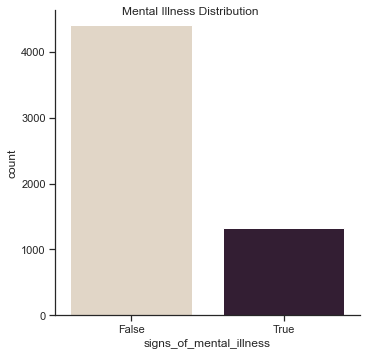

In [675]:
ax = sns.catplot(x="signs_of_mental_illness", kind="count", palette="ch:.25", data=intact)
ax.fig.suptitle('Mental Illness Distribution')

#### Inspecting different features and counts 

In [676]:
#Checking weapon distribution
pd.crosstab(data.armed, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
armed,,
gun,0.790334,0.209666
knife,0.626207,0.373793
other,0.658427,0.341573
toy weapon,0.558659,0.441341
unarmed,0.811377,0.188623
undetermined,0.905956,0.094044
vehicle,0.950704,0.049296


Text(0.5, 0.98, 'Mental Illness Distribution with Armed Type')

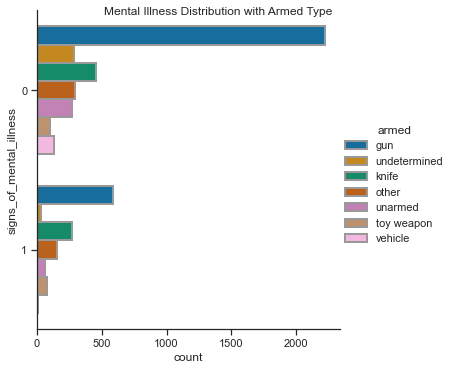

In [677]:
#Plotting out weapon distribution
ax = sns.catplot(y="signs_of_mental_illness", hue="armed", kind="count",
            palette="colorblind", edgecolor=".6",
            data=data, linewidth=2)
ax.fig.suptitle('Mental Illness Distribution with Armed Type')

In [678]:
#Checking race distribution 
pd.crosstab(intact.race, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
race,,
A,0.755319,0.244681
B,0.845414,0.154586
H,0.819810,0.180190
N,0.814815,0.185185
O,0.787234,0.212766
W,0.705000,0.295000


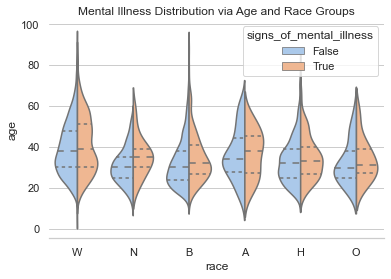

In [679]:

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="race", y="age",  hue="signs_of_mental_illness",
               split=True, inner="quart",
               data=intact).set_title('Mental Illness Distribution via Age and Race Groups')
sns.despine(left=True)


##### Each ethnicity has its own distribution among age groups.  'W' (White, non-Hispanic) and 'A' (Asian) outpace other ethnicities by several precentage points. 'W,' in particular, makes up for almost a third of the positive mental illness stats, peaking in the 30s and remaining present until the mid 70s. 

In [680]:
#Checking gender disparity
pd.crosstab(intact.gender, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
gender,,
F,0.662698,0.337302
M,0.773100,0.226900


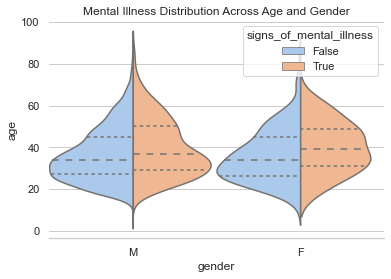

In [681]:

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="gender", y="age",  hue="signs_of_mental_illness",
               split=True, inner="quart",
               data=intact, width=1).set_title('Mental Illness Distribution Across Age and Gender')
sns.despine(left=True)

##### Nearly a third of women fatally shot by police display signs of mental illness. Unlike men, this trend stays consistent regardless of age. 

Text(0.5, 0.98, 'Mental Illness Distribution Sorted by Gender and Race')

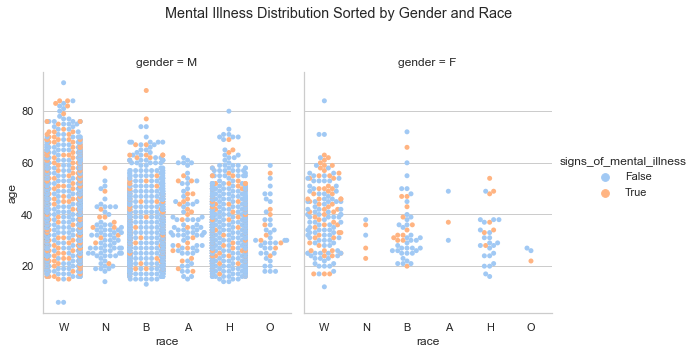

In [682]:
#Checking gender disparity while race
ax = sns.catplot(x="race", y="age", hue="signs_of_mental_illness",
            col="gender", aspect=.8,
            kind="swarm", data=intact)
plt.subplots_adjust(top=.8)
ax.fig.suptitle('Mental Illness Distribution Sorted by Gender and Race')

Text(0.5, 0.98, 'Mental Illness Distribution Across Regions and Genders')

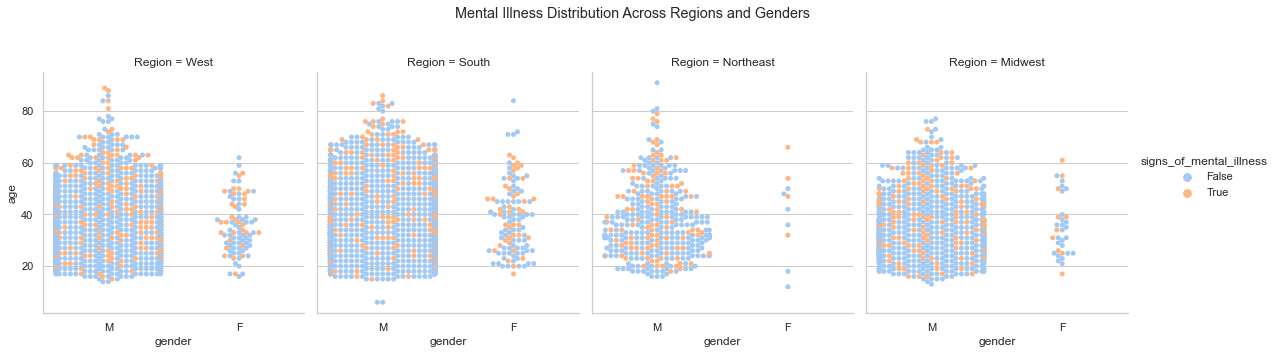

In [683]:
#Checking gender disparity while examining region
ax = sns.catplot(x="gender", y="age", hue="signs_of_mental_illness",
            col="Region", aspect=.8,
            kind="swarm", data=intact)
plt.subplots_adjust(top=0.8)
ax.fig.suptitle('Mental Illness Distribution Across Regions and Genders')

Text(0.5, 0.98, 'Mental Illness Distribution Sorted by Gender and Race')

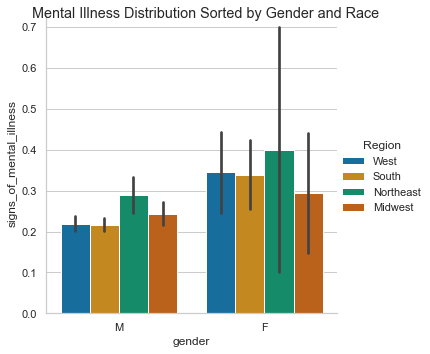

In [684]:
#Keep Northeast in context with available information
ax = sns.catplot(x="gender", y="signs_of_mental_illness", hue="Region", kind="bar", data=intact, palette='colorblind')
ax.fig.suptitle('Mental Illness Distribution Sorted by Gender and Race')

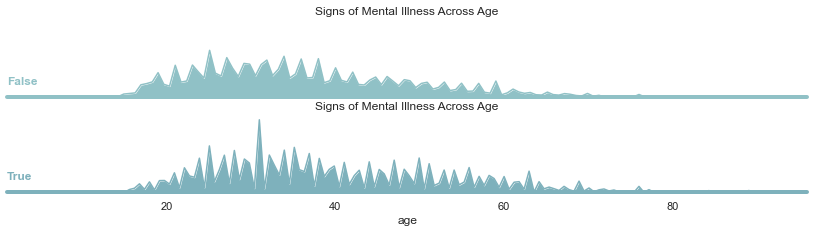

In [685]:

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(intact, row="signs_of_mental_illness", hue="signs_of_mental_illness", 
                  aspect=7, height=1.7, palette=pal)


g.map(sns.kdeplot, "age", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(plt.axhline, y=0, lw=4, clip_on=False)


def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "age")


g.fig.subplots_adjust(hspace=.25)


g.set_titles("Signs of Mental Illness Across Age")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [686]:
#Checking Division distribution
pd.crosstab(intact.Division, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
Division,,
East North Central,0.746403,0.253597
East South Central,0.805621,0.194379
Middle Atlantic,0.703448,0.296552
Mountain,0.805621,0.194379
New England,0.721154,0.278846
Pacific,0.753401,0.246599
South Atlantic,0.750000,0.250000
West North Central,0.769886,0.230114
West South Central,0.795895,0.204105


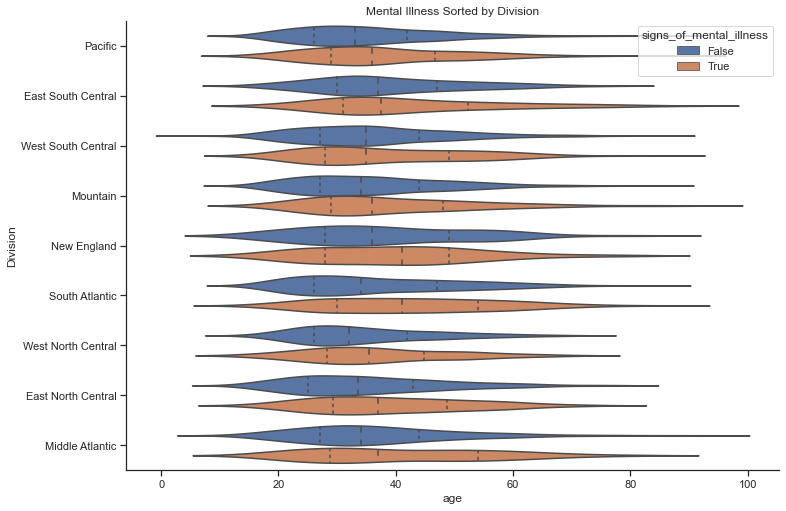

In [687]:
# plotting Division distribution
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.violinplot(x="age", y="Division", hue="signs_of_mental_illness",
            kind="violin", data=intact, inner="quart", ax=ax).set_title('Mental Illness Sorted by Division')    
sns.despine()


##### Lacking uniform distribution, each age group in each Division requires independent analysis. 

Text(0.5, 0.98, 'Mental Illness Sorted by Gender and Response (Flee)')

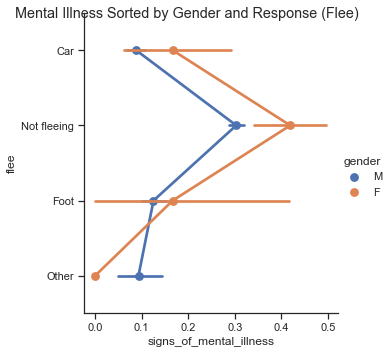

In [688]:
ax = sns.catplot(x="signs_of_mental_illness", y="flee", hue="gender", kind="point", data=data)
ax.fig.suptitle('Mental Illness Sorted by Gender and Response (Flee)')

Text(0.5, 0.98, 'Spread of Casualties with MI Sorted by Threat Level')

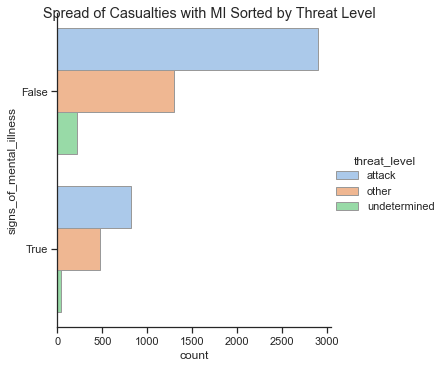

In [689]:
ax = sns.catplot(y="signs_of_mental_illness", hue="threat_level", kind="count",
            palette="pastel", edgecolor=".6",
            data=intact)
ax.fig.suptitle('Spread of Casualties with MI Sorted by Threat Level')

Text(0.5, 1.0, 'An Examination of Threat Level, Age, and MI Signs')

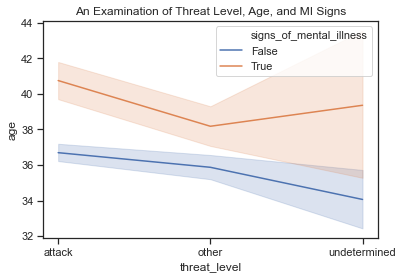

In [690]:
sns.lineplot(x='threat_level', y='age', data=df, hue='signs_of_mental_illness').set_title('An Examination of Threat Level, Age, and MI Signs')


#### 4A. Initial Analysis and EDA 2 of 2
Below is an automated EDA for the entirety of the dataset, breaking down each categorical and continuous variable. 

The data looks like this: 
   state Region Division        date manner_of_death         armed   age  \
0    AK   West  Pacific  2015-02-08            shot           gun  33.0   
1    AK   West  Pacific  2015-09-08            shot           gun  19.0   
2    AK   West  Pacific  2015-09-09            shot           gun  33.0   
3    AK   West  Pacific  2015-10-24            shot  undetermined  49.0   
4    AK   West  Pacific  2016-01-12            shot         knife  49.0   

  gender race             city  signs_of_mental_illness threat_level  \
0      M    W        Anchorage                        0       attack   
1      M    N        Fairbanks                        0       attack   
2      M    N        Fairbanks                        0       attack   
3      M    W  Kenai Peninsula                        0       attack   
4      M    N          Spenard                        1        other   

          flee  body_camera  longitude  latitude  is_geocoding_exact  
0          Car   

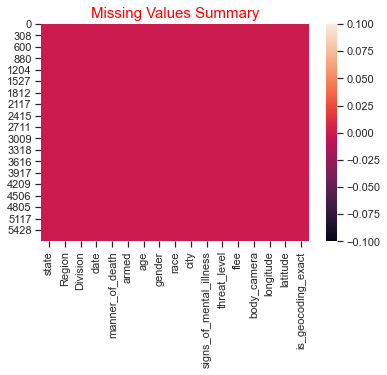

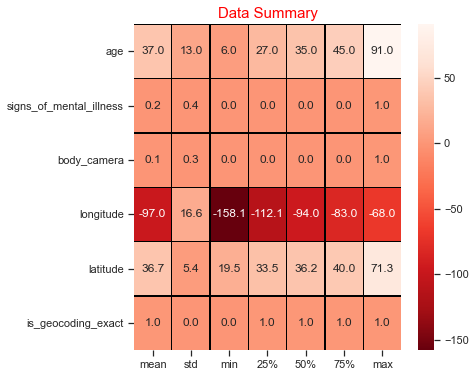

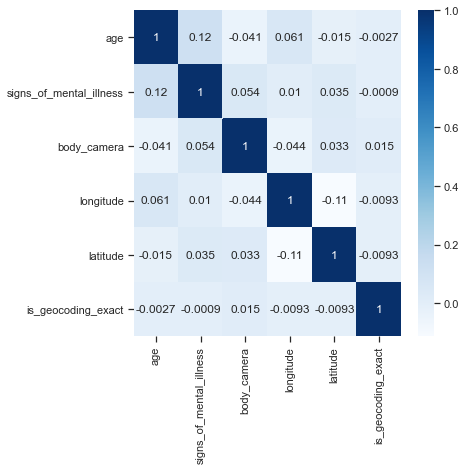

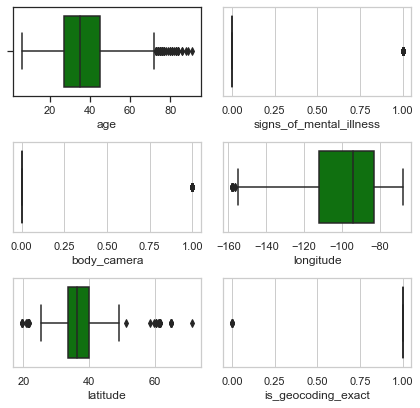

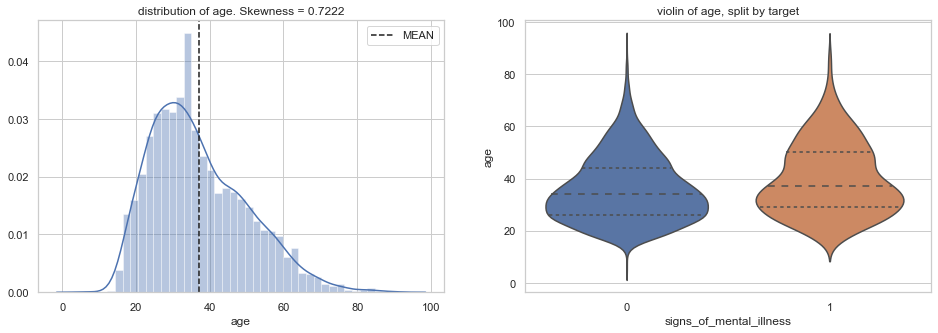

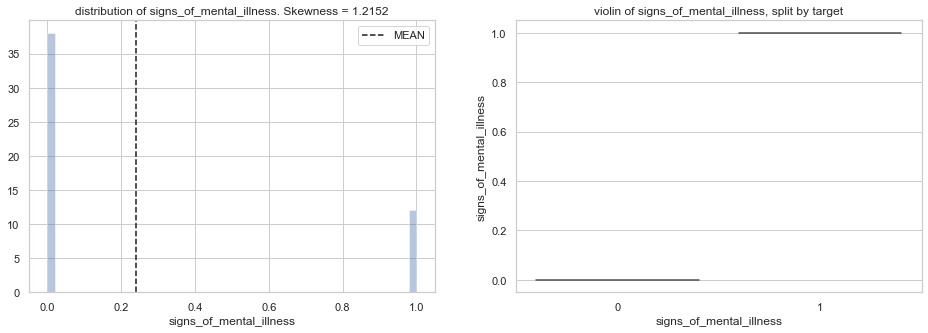

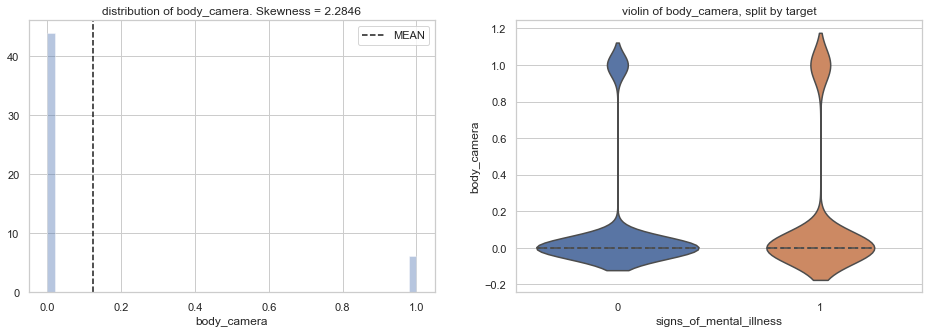

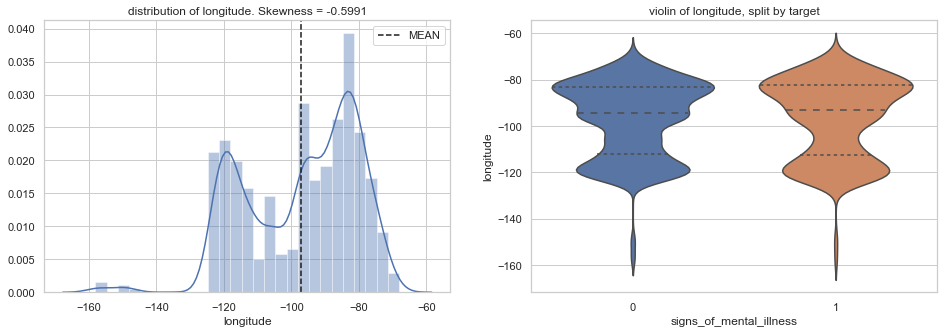

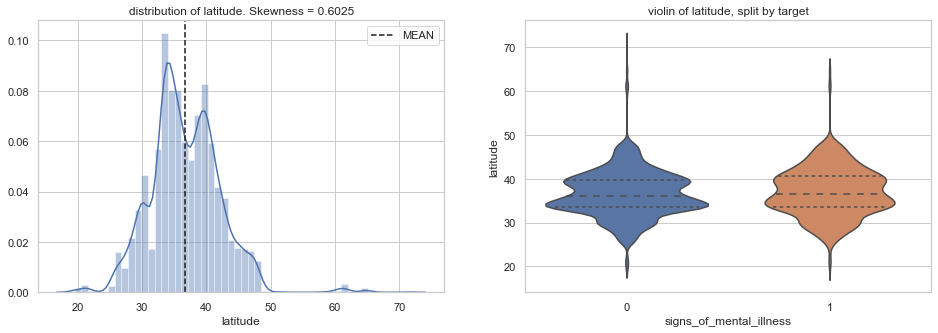

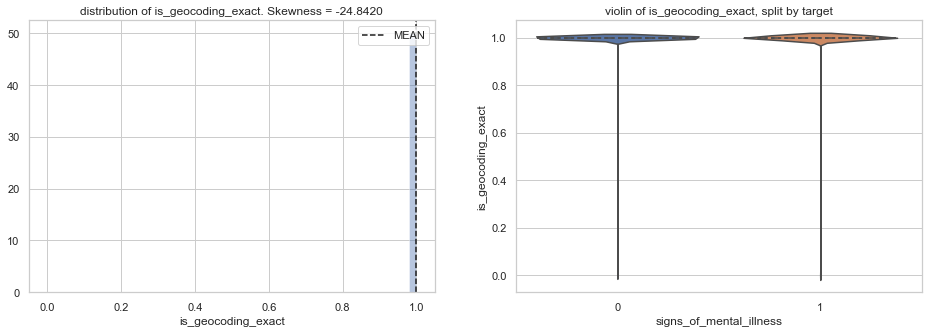

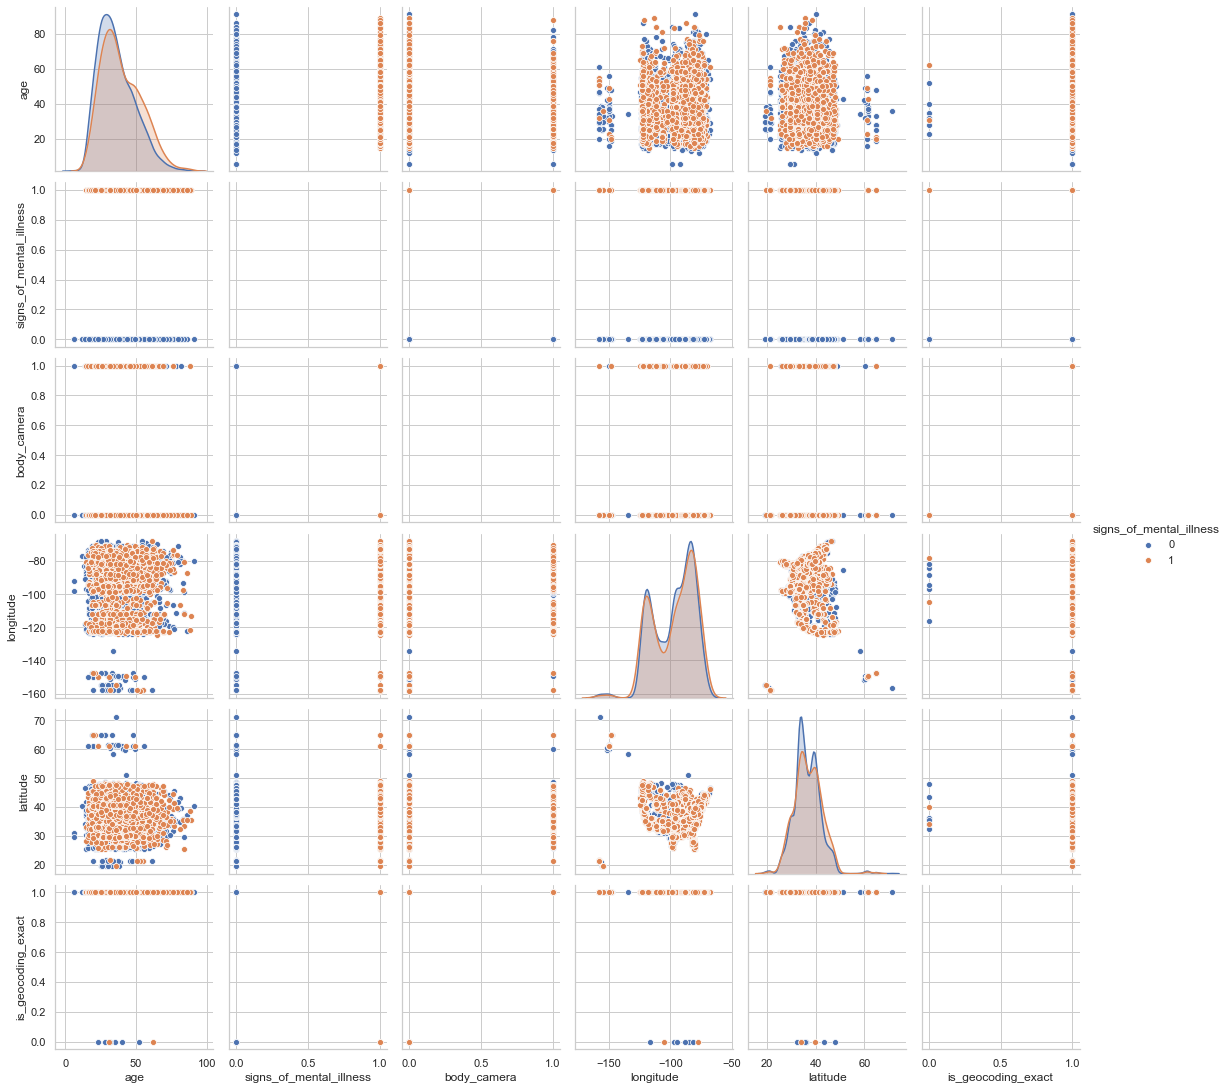

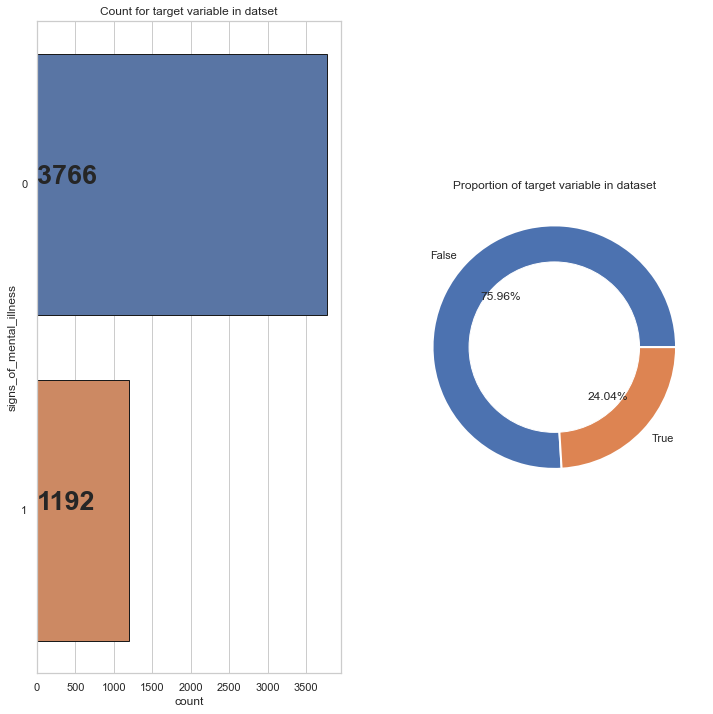

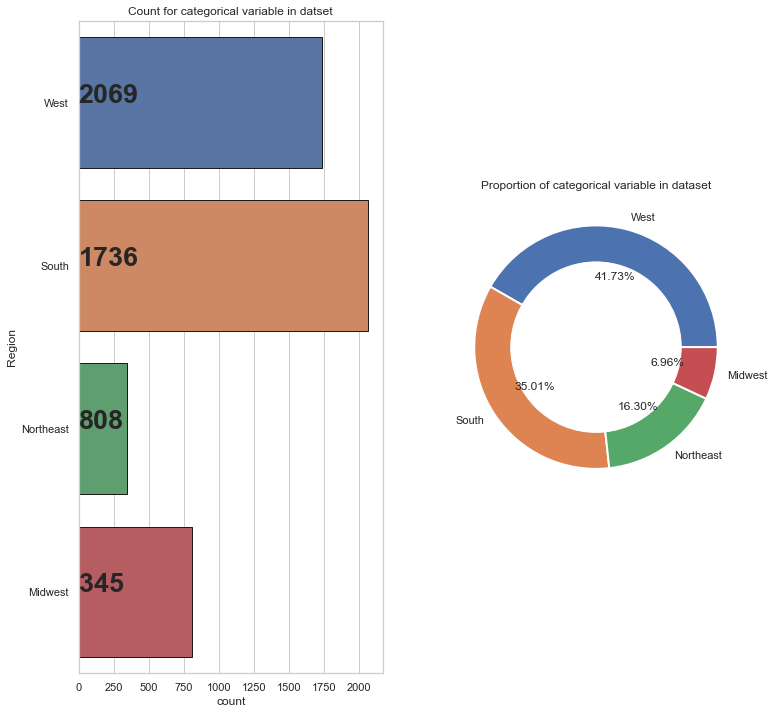

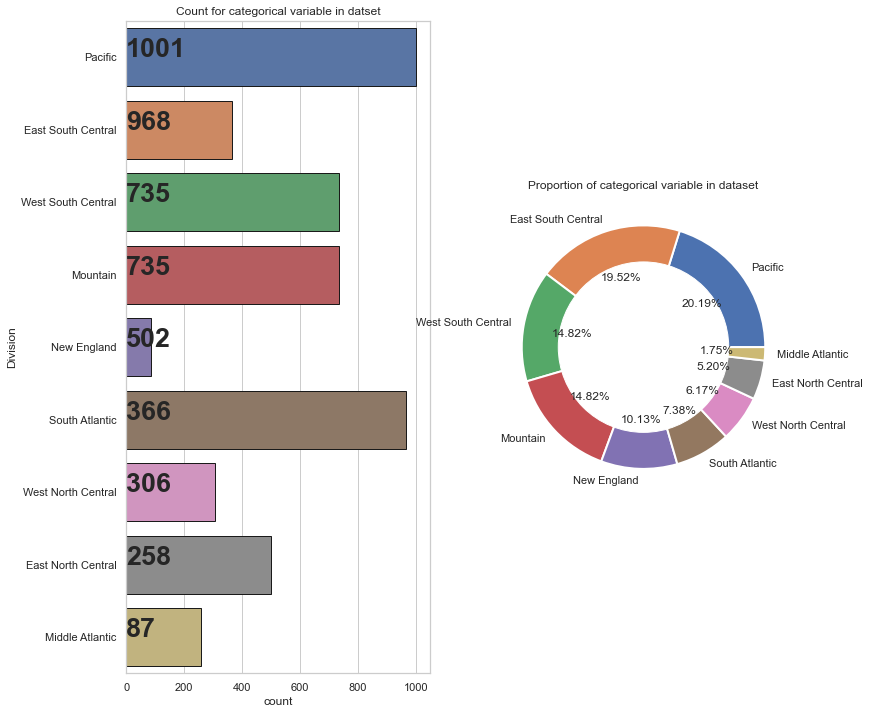

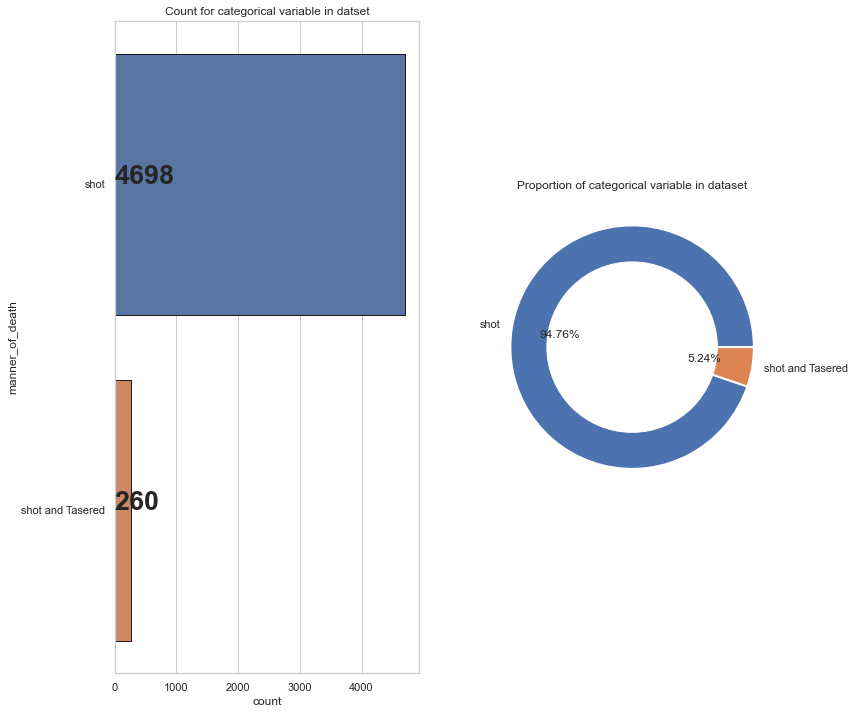

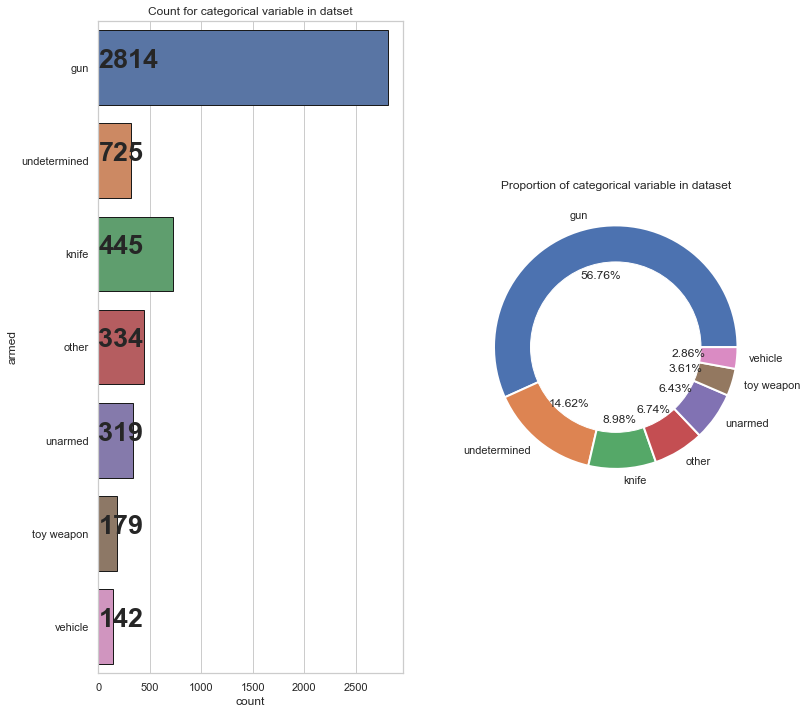

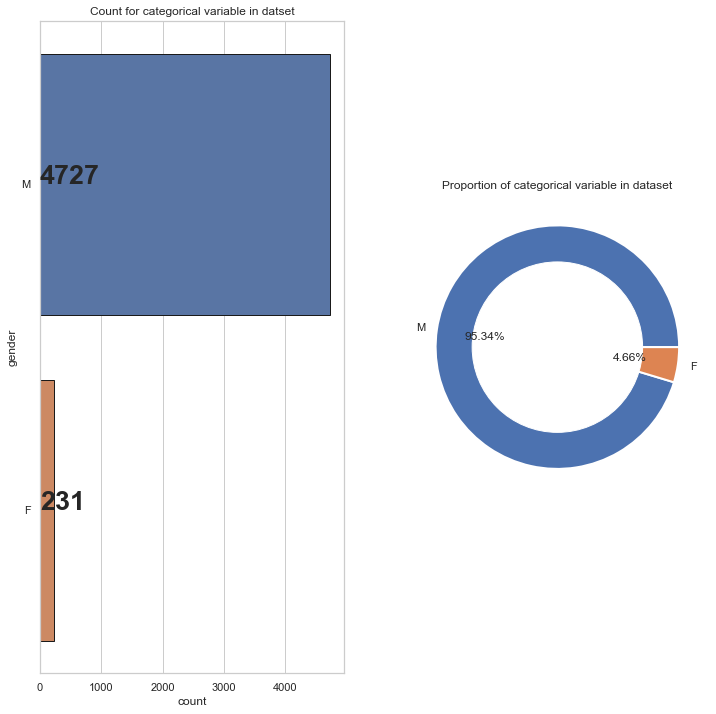

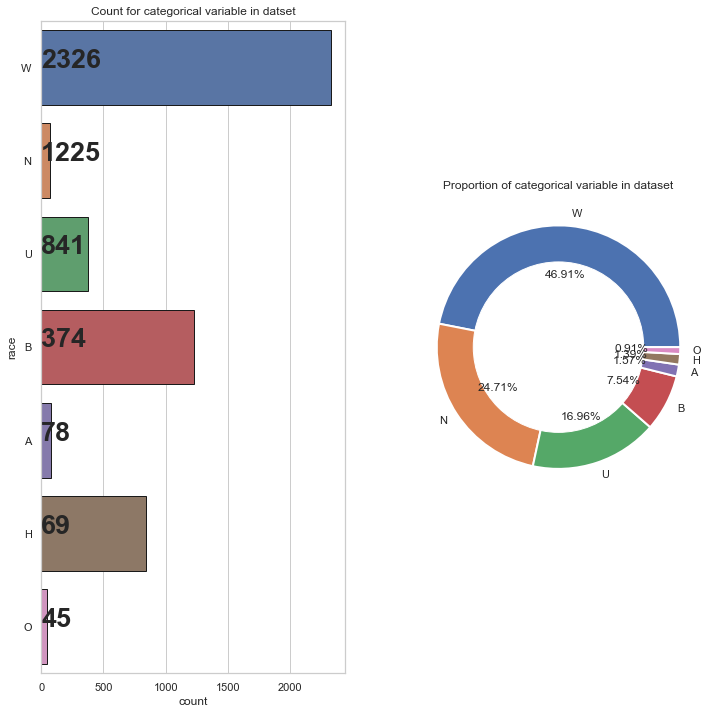

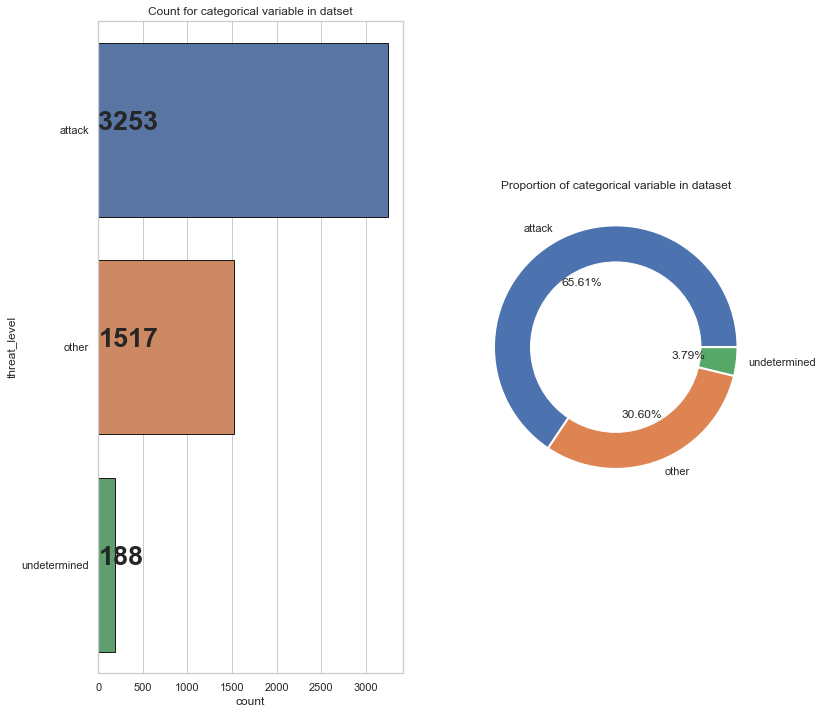

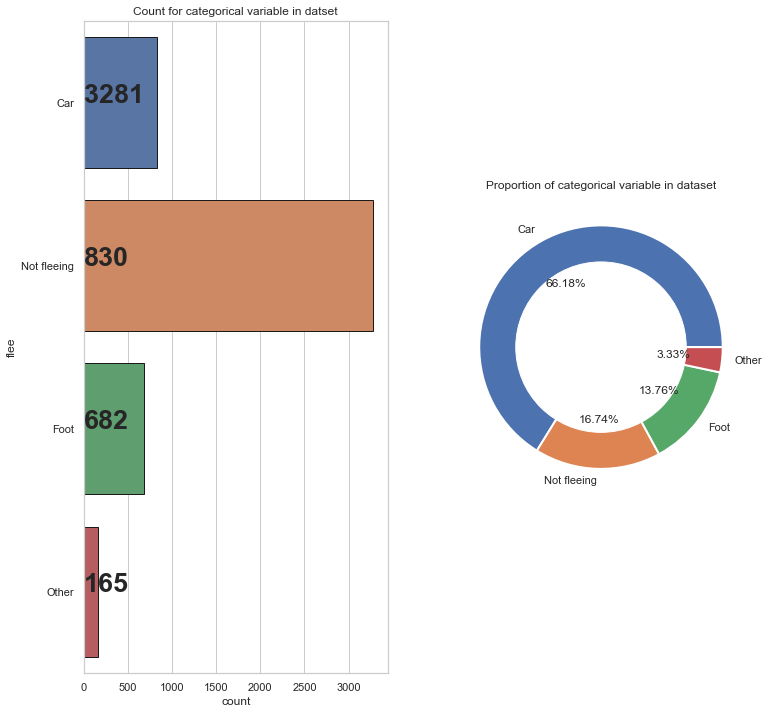

In [691]:
#Automated EDA 
labels=["False","True"]
target_variable_name='signs_of_mental_illness'
df_processed,num_features,cat_features=EDA(data,labels,
                                         target_variable_name,
                                         data_summary_figsize=(6,6),
                                         corr_matrix_figsize=(6,6),
                                         corr_matrix_annot=True,
                                         pairplt=True)

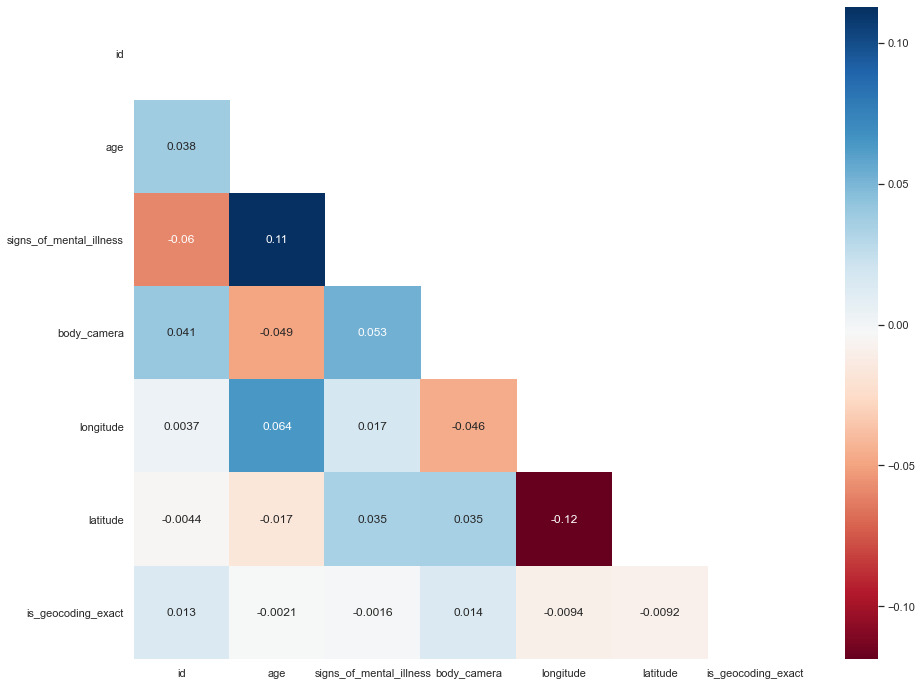

In [692]:
plt.figure(figsize=(15,12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='RdBu', annot = True)

### 5. Final Prep Stage for Modeling: Scaling Continuous Data and Creating Dummy DF

In [693]:
#Scaling lat, long, and age data.
mms = MinMaxScaler()

data[['longitude', 'latitude', 'age']] = mms.fit_transform(data[['longitude', 'latitude', 'age']])

In [694]:
#Creating Dummy DF
dummydf = pd.get_dummies(data)
dummydf.head()

,age,signs_of_mental_illness,body_camera,longitude,latitude,is_geocoding_exact,state_AK,state_AL,state_AR,state_AZ,...,city_Yuma,city_Zanesville,city_Zion,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,0.317647,0,0,0.091852,0.805166,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.152941,0,0,0.114932,0.875027,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.317647,0,0,0.117550,0.874621,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0.505882,0,0,0.076052,0.787387,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.505882,1,0,0.091420,0.804857,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


###### Creating target and feature variables

In [695]:
#One more check of value counts before model analysis. 
data['signs_of_mental_illness'].value_counts()

0    3766
1    1192
Name: signs_of_mental_illness, dtype: int64

In [696]:
y = dummydf['signs_of_mental_illness']
X = dummydf.drop('signs_of_mental_illness', axis=1)

### 6.  Creating Train/Test Sets and Comparing Methods of Analysis

In [697]:
#Reshaping Y after errors in checking accuracy 
#y = y.values.reshape(4958,1)
#y.shape

In [832]:
#Setting train/test size to 70/20 and setting random_state 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1487, 4292) (1487,)
(3471, 4292) (3471,)


In [699]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    753
1    238
Name: signs_of_mental_illness, dtype: int64


0    3013
1     954
Name: signs_of_mental_illness, dtype: int64


Prepping for visualization of different analysis methods 

In [700]:
#Taking note of n_estimators, which will be assigned to deeper RF analysis 
classifier_ls = ['Logistic_Regression', 'Random_Forest', 'Decision_Tree', 'Gradient_Boosting', 'K_NN']
classifier_dc = {
               'Logistic_Regression': LogisticRegression(class_weight='auto'),
               'Random_Forest': RandomForestClassifier(n_estimators=50, class_weight='balanced'), 
               'Decision_Tree':DecisionTreeClassifier(class_weight='balanced'),
               'Gradient_Boosting': GradientBoostingClassifier(max_depth=5),
               'K_NN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
               }
n_trials = 20
test_size_rt = 0.2

In [701]:
score_ls = []
for ic, (cl_name, Classifier) in enumerate(classifier_dc.items()):
    for trial in range(n_trials):
        train_signals, test_signals, train_labels, test_labels = train_test_split(X, y, test_size=test_size_rt, random_state=42)
        Classifier.fit(train_signals, train_labels)
        pred_labels = Classifier.predict(test_signals)
        precision = precision_score(test_labels, pred_labels, average='binary')
        score_ls.append([cl_name, precision, 'Precision'])
        recall = recall_score(test_labels, pred_labels, average='binary')
        score_ls.append([cl_name, recall,'Recall'])
        F1 = f1_score(test_labels, pred_labels, average='binary')
        score_ls.append([cl_name, F1,'f1 Score'])


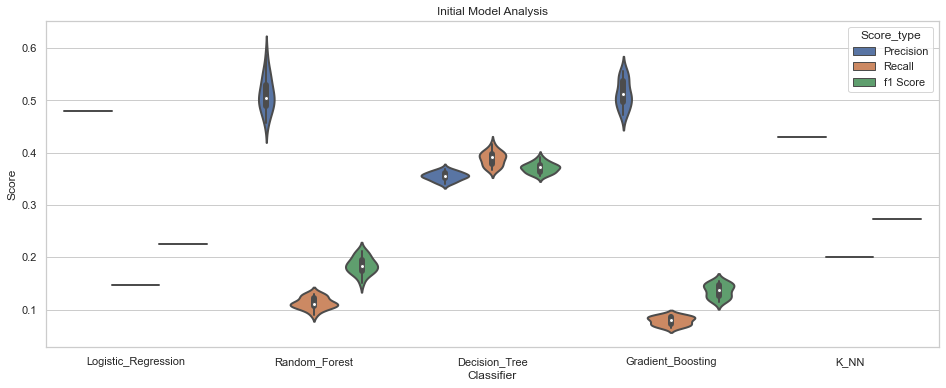

In [702]:
# Visualizing analysis methods 
plt.figure(figsize=(16, 6))
metrics_df = pd.DataFrame(score_ls, columns=['Classifier','Score','Score_type']) 
ax = sns.violinplot(x="Classifier", y="Score", hue="Score_type", data=metrics_df, linewidth=2).set_title('Initial Model Analysis')

#### These aren't great scores, but it's a place to start. We'll keep a close eye on each mnetric as we tune the data. 
1. While Gradient Boosting has a similar precision as Random Forest, its other scores are quite low. Future analysis may expand upon Gradient Boosting, but at this time, we will forgo indepth Gradient Boosting analysis
2. Random Forest's class weight and estimators will be further tuned below. Sampling may contribute to lower scores. 
3. The Decision Tree Classifier was added after further analysis of the model. While the scores look low now, we will tune the model to improve its overall performance. 
4. As demonstrated below, Logreg's performance will stay below our other chosen models.

### 7. Logistic Regression (Model 1 of 3)
###### Steps
1. Assign LogReg
2. Check accuracy
3. ROC
4. Confusion matrix
5. Investigate scores

In [843]:
#Increased max_iter from default (100)
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [844]:
k_predictions = cross_val_predict(logreg, X, y, cv=10)
kfold_scores = cross_val_score(logreg, X, y, cv=10, scoring='neg_mean_squared_error')
print(kfold_scores.mean())


-0.36224014336917565


In [845]:
print("Train Accuracy:",logreg.score(X_train, y_train))
print("Test Accuracy:",logreg.score(X_test, y_test))

Train Accuracy: 0.8991257565568258
Test Accuracy: 0.7551138000576203


**ABOVE:** We're seeing some overfitting in our data. We'll see if this continues across our models. 

In [846]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


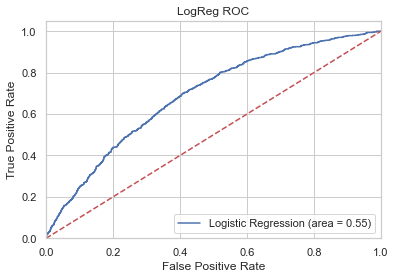

In [847]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogReg ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [848]:
model_1 = LogisticRegression()
cross_val = KFold(n_splits=3, random_state=42)
scores = cross_val_score(model_1, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Logistic Regression: ", scores.mean())

Mean AUC Score - Logistic Regression:  0.6859405081922922


Checking different parameters for Logreg - requires subset analysis 

In [849]:
#tuned_parameters = [{'C': np.linspace(.0001, 1000, 200) , 'penalty': [ "l1", "l2"]}]
#clf = GridSearchCV(logreg, tuned_parameters, cv=cross_val, scoring= 'roc_auc')
#clf.fit(X_train, y_train)
#print("Best parameters set found on development set:")
#print()
#print(clf.best_params_)
#print("\nOptimized model achieved an ROC of:" \
      #,round(clf.score(X_train, y_train), 4))

Creating a confusion matrix to evaluate the efficacy of our LogReg model. 

In [850]:
cmlg = confusion_matrix(y_test, y_pred)
print(cmlg)

[[2493  136]
 [ 714  128]]


Confusion Matrix
[[2493  136]
 [ 714  128]]


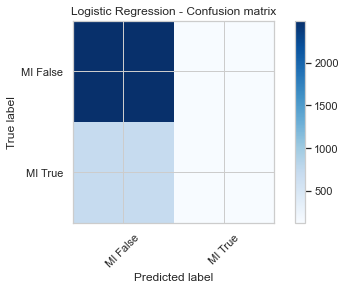

In [851]:
def plot_confusion_matrix(cm, names, title="Logistic Regression - Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion Matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["MI False","MI True"])

**ABOVE:** Our model is highly imbalanced. It's suffering in its ability to predict True MI Signs. 

In [852]:
print('LogReg Analysis', '\n', classification_report(y_test, y_pred))

LogReg Analysis 
               precision    recall  f1-score   support

           0       0.78      0.95      0.85      2629
           1       0.48      0.15      0.23       842

    accuracy                           0.76      3471
   macro avg       0.63      0.55      0.54      3471
weighted avg       0.71      0.76      0.70      3471



#### Let's see if we can do better. 
As we will see below, while our LogReg has a similar accuracy to our DTC, it's doing a better job analyzing positive cases of mental illness (in relationship to the total dataset (recall)). 
However, our weighted averages our very similar to our DTC. 

Due to how uneven our data is, it's best we keep an eye on our F1-score. 



### 8. Decision Tree Classifier (Model 2 of 3)
###### Steps
1. Assign DTC
2. Check AUC and cross_val scores
3. Set parameter grid for hyperparameter tuning
4. Check accuracy and optimal parameters
5. Confusion matrix
6. Investigate scores

In [853]:
#Setting our DTC and fitting the model to our data. 
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [854]:
#Using KFold cross-val to check initial mean AUC score. 
model2 = DecisionTreeClassifier()
cross_val = KFold(n_splits=3, random_state=42)
scores = cross_val_score(model2, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Decision Tree: ", scores.mean())

Mean AUC Score - Decision Tree:  0.5552140060236067


Not good. We'll check other metrics and do some preliminary tuning. 

In [855]:
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 72.09%


In [856]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [857]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [1, 2, 5, 10]},
             return_train_score=True)

In [858]:

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: nan%
Mean Test Score: 75.74%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [859]:
y_pred_test2 = dt_grid_search.predict(X_test)
accuracy_score(y_test, y_pred_test2)

0.7574186113511956

In [860]:
cmdt = confusion_matrix(y_test, y_pred_test2)
print(cmdt)

[[2629    0]
 [ 842    0]]


**Highly imbalanced**
While our model is avoiding overfitting (compared to LogReg), it's suffering in its ability to predict. 

Confusion matrix
[[2629    0]
 [ 842    0]]


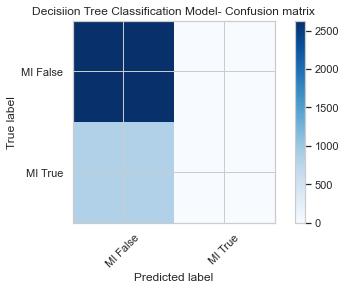

In [861]:
def plot_confusion_matrix(cmdt, names, title="Decisiion Tree Classification Model- Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cmdt, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cmdt = confusion_matrix(y_test, y_pred_test2)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cmdt)
plt.figure()
plot_confusion_matrix(cmdt, ["MI False","MI True"])

In [862]:
print('LogReg Analysis', '\n', classification_report(y_test, y_pred))
print('-----------------------------------------------------------------')
print('*DTC Initial Gridsearch Tuning*', '\n', classification_report(y_test, y_pred_test2))


LogReg Analysis 
               precision    recall  f1-score   support

           0       0.78      0.95      0.85      2629
           1       0.48      0.15      0.23       842

    accuracy                           0.76      3471
   macro avg       0.63      0.55      0.54      3471
weighted avg       0.71      0.76      0.70      3471

-----------------------------------------------------------------
*DTC Initial Gridsearch Tuning* 
               precision    recall  f1-score   support

           0       0.76      1.00      0.86      2629
           1       0.00      0.00      0.00       842

    accuracy                           0.76      3471
   macro avg       0.38      0.50      0.43      3471
weighted avg       0.57      0.76      0.65      3471



#### After hyperparameter tuning and individual analysis, our decision tree model is split in its efficacy. 
1. Our accuracy score is at 76% and the model is excelling in predicting police shooting casualties without mental illness. However...
2. Everything else is suffering. We can see our model needs **much more work** analyzing true cases of mental illness against the rest of the data. 

We'll use feature selection and SMOTE to further tune our data in the next section. 

### 9. Random Forest Classifier (Model 3 of 3)
###### Steps
1. Assign RFC
2. Check AUC and cross_val
3. Set parameter grid for hyperparameter tuning
4. Check accuracy and optimal parameters
5. Compare RFC to DTC
6. Confusion matrix
7. Investigate scores

In [863]:
#Need to investigate class_weight and balance further 
#class_weight = 'balanced' drops all metrics substantially 
#class_weight = 'balanced_subsample' improves metrics slightly
#Need to further exampine sampling
rf_clf = RandomForestClassifier(class_weight = 'balanced_subsample')
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 75.72%


In [864]:
#Using KFold cross-val to check initial mean AUC score. 
model3 = RandomForestClassifier()
kfold = KFold(n_splits=3, random_state=42) 
scores = cross_val_score(model3, X_train, y_train, cv=kfold, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - Random Forest:  0.6607857737436983


Initial AUC score via KFold validation is higher than our DTC. Let's set a grid and examine our CM. 

Tune the model. 

In [865]:
#Setting parameter grid for tuning
rf_param_grid = {
    'n_estimators': [10, 30, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 7, 10],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 3, 6, 9]
}

In [866]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 75.39%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [867]:
#Comparing DTC and RFC grid search scores - accuracy
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

Decision tree grid search:  0.7574186113511956
Random forest grid search:  0.7548256986459234


Our RFC model is scoring lower than our DTC model (using an overall accuracy metric). 

In [868]:
#Checking Train/Test Scores
rf_gs_training_score = mean_rf_cv_score

rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Mean Training Score: 75.72%
Mean Test Score: 75.48%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

Our RFC model is overfitting and lacking accuracy compared to our previous models. 

In [869]:
pred = rf_grid_search.predict(X_test)
accuracy_score(y_test, pred)

0.7548256986459234

In [870]:
cmrf = confusion_matrix(y_test, pred)
print(cmrf)

[[2507  122]
 [ 729  113]]


Confusion matrix
[[2507  122]
 [ 729  113]]


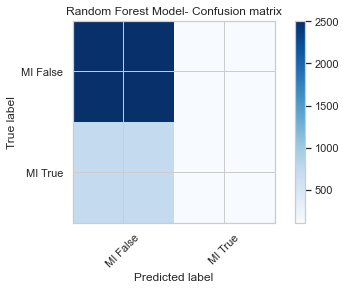

In [871]:
def plot_confusion_matrix(cmrf, names, title="Random Forest Model- Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["MI False","MI True"])

In [872]:
print('LogReg Analysis', '\n', classification_report(y_test, y_pred))
print('-----------------------------------------------------------------')
print('DTC Scores, Initial Hyperparameter Tuning', '\n', classification_report(y_test, y_pred_test2))
print('-----------------------------------------------------------------')
print('*RFC Scores, Initial Hyperparameter Tuning*', '\n', classification_report(y_test, pred))


LogReg Analysis 
               precision    recall  f1-score   support

           0       0.78      0.95      0.85      2629
           1       0.48      0.15      0.23       842

    accuracy                           0.76      3471
   macro avg       0.63      0.55      0.54      3471
weighted avg       0.71      0.76      0.70      3471

-----------------------------------------------------------------
DTC Scores, Initial Hyperparameter Tuning 
               precision    recall  f1-score   support

           0       0.76      1.00      0.86      2629
           1       0.00      0.00      0.00       842

    accuracy                           0.76      3471
   macro avg       0.38      0.50      0.43      3471
weighted avg       0.57      0.76      0.65      3471

-----------------------------------------------------------------
*RFC Scores, Initial Hyperparameter Tuning* 
               precision    recall  f1-score   support

           0       0.77      0.95      0.85      26

*Great!*
Much more balanced than our first two models. 
Our RFC model is picking up on the positive signs of mental illness, as opposed to both the LogReg and DTC models.


In the next section, we'll further tune our data and address the imbalance and fit. 

### 10. Fine Tuning Data, DTC

#### 10A. Setting Feature Importance, prep for SMOTE

In [873]:
#Checking current shape of our data
X.shape

(4958, 4292)

Setting feature importance and selecting features from model to transform our X. 

In [874]:
dttc = DecisionTreeClassifier()
dttc = dttc.fit(X, y)
dttc.feature_importances_  
model = SelectFromModel(dttc, prefit=True)
X_new = model.transform(X)
X_new.shape               

(4958, 588)

Creating new Train/Test Split with transformed X and setting values (keeping split to 0.7)

In [875]:
X_train1, X_test1, y_train, y_test = train_test_split(X_new, y, test_size=0.7, random_state=42)
print(X_train1.shape, y_train.shape)
print(X_test1.shape, y_test.shape)

(1487, 588) (1487,)
(3471, 588) (3471,)


Fitting our transformed X to a new DTC, checking AUC score before proceeding. We have not fixed our imbalance issues. 

In [876]:
dt_clf1 = DecisionTreeClassifier()
dt_clf1.fit(X_train1, y_train)

DecisionTreeClassifier()

In [877]:
#model2a = DecisionTreeClassifier()
cross_val = KFold(n_splits=3, random_state=42)
scores = cross_val_score(dt_clf1, X_train1, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Decision Tree: ", scores.mean())

Mean AUC Score - Decision Tree:  0.572313927368382


**Note:** Our original model's confusion matrix and target scores have not been addressed, so we will move to SMOTE resampling. 

In [878]:

print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
X1, y1 = smote.fit_resample(X, y)

print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    3766
1    1192
Name: signs_of_mental_illness, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    1137
0    1137
Name: signs_of_mental_illness, dtype: int64


Setting up a new test/train split for our SMOTE/Feature Selection

**ABOVE** is the SMOTE resampled test/train split. 

**BELOW** is the transformed X with SMOTE resampling

In [879]:
X_train_resampled1, y_train_resampled = smote.fit_sample(X_train1, y_train) 

#### 10B. DTC with Oversampling via SMOTE, No Feature Selection

###### Update our Tuning with SMOTE Train Values


In [880]:
#Setting up a new DTC with resampled values
dt_clf2 = DecisionTreeClassifier()
dt_clf2.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

In [881]:
#Checking Cross Val Score
dt_cv_score = cross_val_score(dt_clf2, X_train_resampled, y_train_resampled, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 74.93%


In [882]:
#Using an expanded grid search for our new SMOTE values. 
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [883]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf2, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [884]:

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 74.15%
Mean Test Score: 68.28%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Our overall score is lower than our initial DTC, but let's look at our scores. We're seeing a little bit of a fit issue. 

In [885]:
y_pred_test2a = dt_grid_search.predict(X_test)
accuracy_score(y_test, y_pred_test2a)

0.682800345721694

In [886]:
cmdt = confusion_matrix(y_test, y_pred_test2a)
print(cmdt)

[[2074  555]
 [ 546  296]]


Confusion matrix
[[2074  555]
 [ 546  296]]


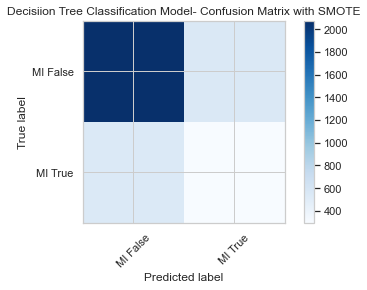

In [887]:
def plot_confusion_matrix(cmdt, names, title="Decisiion Tree Classification Model- Confusion Matrix with SMOTE", cmap=plt.cm.Blues):
    plt.imshow(cmdt, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cmdt = confusion_matrix(y_test, y_pred_test2a)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cmdt)
plt.figure()
plot_confusion_matrix(cmdt, ["MI False","MI True"])

In [888]:
print('Initial DTC w/o SMOTE', '\n', classification_report(y_test, y_pred_test2))
print('-----------------------------------------------------------------')
print('*DTC with SMOTE*', '\n', classification_report(y_test, y_pred_test2a))


Initial DTC w/o SMOTE 
               precision    recall  f1-score   support

           0       0.76      1.00      0.86      2629
           1       0.00      0.00      0.00       842

    accuracy                           0.76      3471
   macro avg       0.38      0.50      0.43      3471
weighted avg       0.57      0.76      0.65      3471

-----------------------------------------------------------------
*DTC with SMOTE* 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      2629
           1       0.35      0.35      0.35       842

    accuracy                           0.68      3471
   macro avg       0.57      0.57      0.57      3471
weighted avg       0.68      0.68      0.68      3471



**RESULTS**
1. While our overall accuracy is lower with SMOTE, our model is much more balanced. Our weighted averages are much higher than our initial DTC model. Our macro average for our F1 score increased substantially. 
2. Our model is still struggling to predict true cases of mental illness. 
3. Additional data may solve some of these issues. 

#### 10C. Applying Transformed X (feature selection) and SMOTE

In [889]:
#Assigning new DTC with feature selected X and SMOTE
dt_clf3 = DecisionTreeClassifier()
dt_clf3.fit(X_train_resampled1, y_train_resampled)

DecisionTreeClassifier()

In [890]:
#Checking Cross Val Score
dt_cv_score = cross_val_score(dt_clf3, X_train_resampled1, y_train_resampled, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 79.42%


In [891]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf3, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train_resampled1, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [892]:

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

dt_gs_testing_score = dt_grid_search.score(X_test1, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 76.38%
Mean Test Score: 69.03%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [893]:
y_pred_test2b = dt_grid_search.predict(X_test1)
accuracy_score(y_test, y_pred_test2b)

0.6902909824258139

In [894]:
cmdt = confusion_matrix(y_test, y_pred_test2b)
print(cmdt)

[[2126  503]
 [ 572  270]]


Confusion matrix
[[2126  503]
 [ 572  270]]


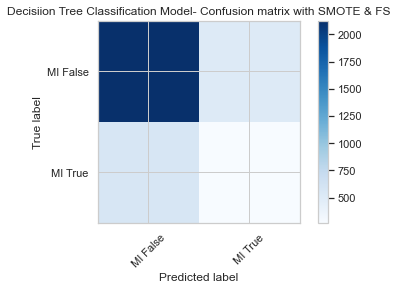

In [895]:
def plot_confusion_matrix(cmdt, names, title="Decisiion Tree Classification Model- Confusion matrix with SMOTE & FS", cmap=plt.cm.Blues):
    plt.imshow(cmdt, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cmdt = confusion_matrix(y_test, y_pred_test2b)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cmdt)
plt.figure()
plot_confusion_matrix(cmdt, ["MI False","MI True"])

In [896]:
print('Initial DTC w/o SMOTE', '\n',classification_report(y_test, y_pred_test2))
print('-----------------------------------------------------------------')
print('DTC with SMOTE, no FS', '\n',classification_report(y_test, y_pred_test2a))
print('-----------------------------------------------------------------')
print('*DTC with SMOTE and FS*', '\n', classification_report(y_test, y_pred_test2b))

Initial DTC w/o SMOTE 
               precision    recall  f1-score   support

           0       0.76      1.00      0.86      2629
           1       0.00      0.00      0.00       842

    accuracy                           0.76      3471
   macro avg       0.38      0.50      0.43      3471
weighted avg       0.57      0.76      0.65      3471

-----------------------------------------------------------------
DTC with SMOTE, no FS 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      2629
           1       0.35      0.35      0.35       842

    accuracy                           0.68      3471
   macro avg       0.57      0.57      0.57      3471
weighted avg       0.68      0.68      0.68      3471

-----------------------------------------------------------------
*DTC with SMOTE and FS* 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      2629
           1       0.35      0.

##### DTC Comparison
    - Without SMOTE, our model suffers from a heavy balance problem, despite a 'promising' accuracy score. 
    - With SMOTE, no FS, our model is working as intended. There's a small hit to our accuracy, but our averages are higher across the board. As our classes are still imbalanced, we should keep an eye on our f1-score macro average. 
    - With SMOTE *and* FS, our model outperforms the first, but is nearly identical to the second (SMOTE, no FS).

### 11. Fine Tuning Data, RFC

#### 11A. Setting Feature Importance, Feature Selection Model, prep for SMOTE

In [897]:
#Transforming our variables for our RFC model. 
rffc = RandomForestClassifier(class_weight = 'balanced_subsample')
rffc = rffc.fit(X, y)
rffc.feature_importances_  
model = SelectFromModel(rffc, prefit=True)
X_new1 = model.transform(X)
X_new1.shape               

(4958, 704)

In [898]:
#Checking shape and setting split. 
X_train2, X_test2, y_train, y_test = train_test_split(X_new1, y, test_size=0.7, random_state=42)
print(X_train2.shape, y_train.shape)
print(X_test2.shape, y_test.shape)

(1487, 704) (1487,)
(3471, 704) (3471,)


In [899]:
#Fitting our model
rf_clf1 = RandomForestClassifier(class_weight = 'balanced_subsample')
rf_clf1.fit(X_train2, y_train)

#Checking AUC via StratifiedKFold cross-val
cross_val = StratifiedKFold(n_splits=3, random_state=42)
scores = cross_val_score(rf_clf1, X_train2, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - RFC: ", scores.mean())

Mean AUC Score - RFC:  0.6771559208894303


Not much of an improvement over our original RFC model, but an improvement over our DTC model. 
As the score is better, let's hyperparameter tune with our new features. 

In [900]:
rf_grid_search = GridSearchCV(rf_clf1, rf_param_grid, cv=3)
rf_grid_search.fit(X_train2, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")

Training Accuracy: 74.71%


In [901]:
mean_rf_cv_score1 = np.mean(cross_val_score(rf_clf1, X_train2, y_train, cv=3))
#Checking Train/Test Scores
rf_gs_training_score = mean_rf_cv_score1

rf_gs_testing_score = rf_grid_search.score(X_test2, y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Mean Training Score: 75.25%
Mean Test Score: 75.37%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [902]:
pred_rfc1 = rf_grid_search.predict(X_test2)
accuracy_score(y_test, pred_rfc1)

0.7536732929991357

In [903]:
cmrf1 = confusion_matrix(y_test, pred_rfc1)
print(cmrf1)

[[2432  197]
 [ 658  184]]


Our Score has improved and our model is more balanced. 

Confusion matrix
[[2432  197]
 [ 658  184]]


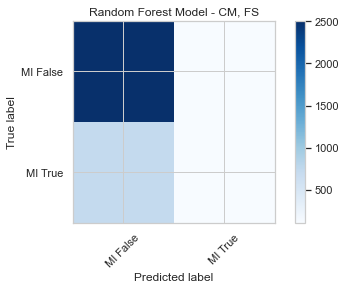

In [904]:
def plot_confusion_matrix(cmrf1, names, title="Random Forest Model - CM, FS", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

np.set_printoptions(precision=2)
print('Confusion matrix')
print(cmrf1)
plt.figure()
plot_confusion_matrix(cmrf1, ["MI False","MI True"])

In [905]:
print('RFC Scores, Initial Hyperparameter Tuning, No FS', '\n',classification_report(y_test, pred))
print('-----------------------------------------------------------------')
print('RFC with FS', '\n',classification_report(y_test, pred_rfc1))

RFC Scores, Initial Hyperparameter Tuning, No FS 
               precision    recall  f1-score   support

           0       0.77      0.95      0.85      2629
           1       0.48      0.13      0.21       842

    accuracy                           0.75      3471
   macro avg       0.63      0.54      0.53      3471
weighted avg       0.70      0.75      0.70      3471

-----------------------------------------------------------------
RFC with FS 
               precision    recall  f1-score   support

           0       0.79      0.93      0.85      2629
           1       0.48      0.22      0.30       842

    accuracy                           0.75      3471
   macro avg       0.63      0.57      0.58      3471
weighted avg       0.71      0.75      0.72      3471



**BELOW:** SMOTE resampling of our feature selected RFC x_train

In [906]:
X_train_resampled2, y_train_resampled2 = smote.fit_sample(X_train2, y_train) 

#### 11B. RFC with Oversampling via SMOTE, No Feature Selection

*Our resampled training set:*
X_train_resampled, y_train_resampled


In [907]:
#Fitting our model
rf_clf2 = RandomForestClassifier(class_weight = 'balanced_subsample')
rf_clf2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced_subsample')

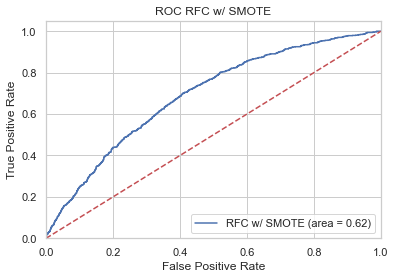

In [908]:
rf_clf2_roc_auc = roc_auc_score(y_test, rf_clf2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RFC w/ SMOTE (area = %0.2f)' % rf_clf2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RFC w/ SMOTE')
plt.legend(loc="lower right")
plt.savefig('rf_clf2')
plt.show()

Not a great AUC - let's try ROC and cross-val:

In [909]:
#Checking AUC via StratifiedKFold cross-val w/ SMOTE
cross_val = StratifiedKFold(n_splits=3, random_state=42)
scores = cross_val_score(rf_clf2, X_train_resampled, y_train_resampled, cv=cross_val, scoring='roc_auc')
print("**Mean AUC Score - RFC w/ SMOTE**: ", scores.mean())

#Checking AUC via StratifiedKFold w/o SMOTE
cross_val = StratifiedKFold(n_splits=3, random_state=42)
scores1 = cross_val_score(rf_clf1, X_train2, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - RFC FS w/o SMOTE: ", scores1.mean())

**Mean AUC Score - RFC w/ SMOTE**:  0.905911264889551
Mean AUC Score - RFC FS w/o SMOTE:  0.6750910353744489


(*Above*)
A **drastic** increase over our previous AUC score with just feature selection.

In [910]:
rf_grid_search = GridSearchCV(rf_clf2, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")

Training Accuracy: 79.38%


In [911]:
mean_rf_cv_score2 = np.mean(cross_val_score(rf_clf2, X_train_resampled, y_train_resampled, cv=3))
#Checking Train/Test Scores
rf_gs_training_score = mean_rf_cv_score2

rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Mean Training Score: 78.50%
Mean Test Score: 67.07%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [912]:
pred_rfc2 = rf_grid_search.predict(X_test)
accuracy_score(y_test, pred_rfc2)

0.6707000864304236

In [913]:
cmrf2 = confusion_matrix(y_test, pred_rfc2)
print(cmrf2)

[[1886  743]
 [ 400  442]]


Confusion matrix
[[1886  743]
 [ 400  442]]


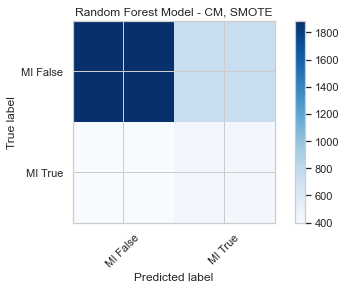

In [914]:
def plot_confusion_matrix(cmrf2, names, title="Random Forest Model - CM, SMOTE", cmap=plt.cm.Blues):
    plt.imshow(cmrf2, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

np.set_printoptions(precision=2)
print('Confusion matrix')
print(cmrf2)
plt.figure()
plot_confusion_matrix(cmrf2, ["MI False","MI True"])

In [915]:
print('RFC with FS', '\n', classification_report(y_test, pred_rfc1))
print('-----------------------------------------------------------------')
print('RFC with SMOTE, no FS', '\n',classification_report(y_test, pred_rfc2))

RFC with FS 
               precision    recall  f1-score   support

           0       0.79      0.93      0.85      2629
           1       0.48      0.22      0.30       842

    accuracy                           0.75      3471
   macro avg       0.63      0.57      0.58      3471
weighted avg       0.71      0.75      0.72      3471

-----------------------------------------------------------------
RFC with SMOTE, no FS 
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      2629
           1       0.37      0.52      0.44       842

    accuracy                           0.67      3471
   macro avg       0.60      0.62      0.60      3471
weighted avg       0.72      0.67      0.69      3471



#### 11C. RFC with Oversampling via SMOTE and Feature Selection

*Our FS SMOTE train/test split**
X_train_resampled2, y_train_resampled2 = smote.fit_sample(X_train2, y_train) 

In [916]:
rf_clf3 = RandomForestClassifier(class_weight = 'balanced_subsample')
rf_clf3.fit(X_train_resampled2, y_train_resampled2)

RandomForestClassifier(class_weight='balanced_subsample')

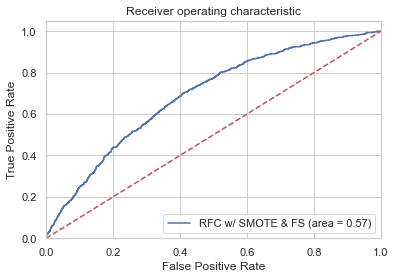

In [917]:
rf_clf3_roc_auc = roc_auc_score(y_test, rf_clf3.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RFC w/ SMOTE & FS (area = %0.2f)' % rf_clf3_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('rf_clf3')
plt.show()

In [918]:
#Checking AUC via StratifiedKfold w/ SMOTE & FS
cross_val = StratifiedKFold(n_splits=3, random_state=42)
scores = cross_val_score(rf_clf3, X_train_resampled2, y_train_resampled2, cv=cross_val, scoring='roc_auc')
print("**Mean AUC Score - RFC w/ SMOTE + FS**: ", scores.mean())

#Checking AUC via StratifiedKFold cross-val w/ SMOTE
cross_val = StratifiedKFold(n_splits=3, random_state=42)
scores = cross_val_score(rf_clf2, X_train_resampled, y_train_resampled, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - RFC w/ SMOTE: ", scores.mean())

#Checking AUC via StratifiedKFold w/o SMOTE, + FS
cross_val = StratifiedKFold(n_splits=3, random_state=42)
scores1 = cross_val_score(rf_clf1, X_train2, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - RFC FS w/o SMOTE: ", scores1.mean())

**Mean AUC Score - RFC w/ SMOTE + FS**:  0.9468443318179814
Mean AUC Score - RFC w/ SMOTE:  0.902074152458792
Mean AUC Score - RFC FS w/o SMOTE:  0.6651958310360638


In [919]:
rf_grid_search = GridSearchCV(rf_clf3, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_resampled2, y_train_resampled2)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")

Training Accuracy: 84.65%


In [920]:
mean_rf_cv_score3 = np.mean(cross_val_score(rf_clf3, X_train_resampled2, y_train_resampled2, cv=3))
#Checking Train/Test Scores
rf_gs_training_score = mean_rf_cv_score3

rf_gs_testing_score = rf_grid_search.score(X_test2, y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Mean Training Score: 85.00%
Mean Test Score: 74.62%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [921]:
pred_rfc3 = rf_grid_search.predict(X_test2)
accuracy_score(y_test, pred_rfc3)

0.7461826562950159

In [922]:
cmrf3 = confusion_matrix(y_test, pred_rfc3)
print(cmrf3)

[[2394  235]
 [ 646  196]]


Confusion matrix
[[2394  235]
 [ 646  196]]


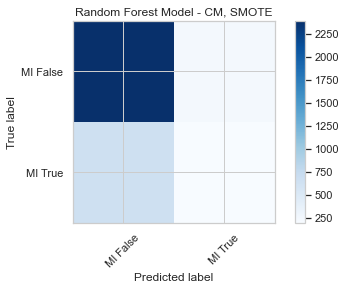

In [923]:
def plot_confusion_matrix(cmrf3, names, title="Random Forest Model - CM, SMOTE", cmap=plt.cm.Blues):
    plt.imshow(cmrf3, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

np.set_printoptions(precision=2)
print('Confusion matrix')
print(cmrf3)
plt.figure()
plot_confusion_matrix(cmrf3, ["MI False","MI True"])

In [924]:
print('RFC with FS','\n', classification_report(y_test, pred_rfc1))
print('-----------------------------------------------------------------')
print('*RFC with SMOTE, no FS*', '\n',classification_report(y_test, pred_rfc2))
print('-----------------------------------------------------------------')
print('RFC with SMOTE & FS', '\n',classification_report(y_test, pred_rfc3))

RFC with FS 
               precision    recall  f1-score   support

           0       0.79      0.93      0.85      2629
           1       0.48      0.22      0.30       842

    accuracy                           0.75      3471
   macro avg       0.63      0.57      0.58      3471
weighted avg       0.71      0.75      0.72      3471

-----------------------------------------------------------------
*RFC with SMOTE, no FS* 
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      2629
           1       0.37      0.52      0.44       842

    accuracy                           0.67      3471
   macro avg       0.60      0.62      0.60      3471
weighted avg       0.72      0.67      0.69      3471

-----------------------------------------------------------------
RFC with SMOTE & FS 
               precision    recall  f1-score   support

           0       0.79      0.91      0.84      2629
           1       0.45      0.23      0.31

### 12. Conclusion

#### Analysis of Model Performance and Best Performers


1. Logistic Regression
    - Accuracy: 75%
    - F1 Score (macro average): 54%
    - **Highly imbalanced**, not a good fit for this data. 
2. Decision Tree Classifier with FS, Gridsearch, and SMOTE
    - Accuracy: 72%
    - F1 Score: 57%
3. Random Forest Classifier with Gridsearch, SMOTE, no FS
    - Accuracy: 61%
    - F1 Score: 60%
    
#### Future Steps 
1. Expand data. 
    - While adding in regions and divisions has eased project visualization, the added data doesn't address our imbalance issues. We need more data on casualties suffering from mental illness. 
    - Expand the time range? 
    - Build a new dataset taking information from local and state datasets? 
2. Balance 
    - Oversampling our target class has improved our metrics, but could more be done by undersampling our features?
    - Across the board, our F1 scores could be improved. Is this possible with our current data? 
3. Model Efficiency 
    - At this moment, our models take quite a bit of time to run. Using a proportioned selection of the data will improve processing time and, depending on the method, may assist with our sampling issue. 
    - This is especially true running a gridsearch for the DTC and RFC models. 
4. ROC/AUC
    - Need to further explore ROC/AUC scores for DTC and RFC. Need to further visualize the mean AUC scores of our high performing RFC models. 

##### Relevant DF and Code Sources
https://github.com/cphalpert/census-regions
https://github.com/washingtonpost/data-police-shootings
http://blog.romanofoti.com/exploratory_classification_analysis/
https://medium.com/analytics-vidhya/automated-eda-for-classification-77c25b847e43